# **Интернет-магазин «Викишоп»**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. 

В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75. 

In [ ]:
!pip install pandarallel -q
!pip install -U spacy  -q

In [ ]:
!python -m spacy download en_core_web_sm -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

import re

from tqdm import trange
from tqdm.auto import tqdm

# import nltk
# from nltk import tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.probability import FreqDist

import spacy
from spacy.lang.en import stop_words


from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

from pandarallel import pandarallel

import warnings
warnings.filterwarnings("ignore")

In [19]:
def plot_graphics(df, 
                  column_name, 
                  test_df=None, 
                  bins=30, 
                  range_hist=None, 
                  hist_color='#519872', 
                  boxplot_color='#B9D2D2', 
                  col_alias='', 
                  xlabel='', 
                  ylabel='', 
                  figsize=(10, 10)):
    
    if test_df is not None:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax = ax.flatten()
    
        ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Train] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
        ax2.set_title(f'[Train] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        
        ax1 = sns.histplot(data=test_df, x=column_name, ax=ax[2], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Test] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=test_df, x=column_name, ax=ax[3], color=boxplot_color)
        ax2.set_title(f'[Test] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        return 

        
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [20]:
sns.set_style('darkgrid')

TEST_SIZE = .25
RANDOM_STATE = 42

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt_tab')

nlp = spacy.load("en_core_web_sm")
stop_words = stop_words.STOP_WORDS

# lemmatizer = WordNetLemmatizer()

# Загрузка данных

In [ ]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    df = pd.read_csv('path', index_col=[0])

In [22]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [24]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [25]:
df.duplicated().sum()

np.int64(0)

# Исследовательский анализ

## Таргет

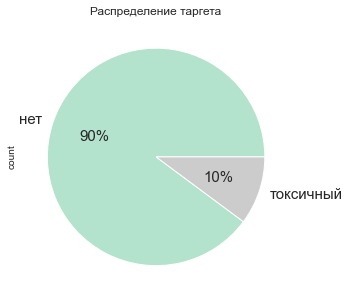

In [26]:
(df
 .toxic
 .replace(
     {
         0: 'нет', 
         1: 'токсичный'
     })
 .value_counts()
 .plot(
       figsize=(5, 5),
       title='Распределение таргета', 
       kind='pie', 
       colormap='Pastel2',
       fontsize=15,
       autopct = "%.0f%%"));

- К сожалению, виден сильный дисбаланс классов. 

Будем решать эту проблему с помощью специального параметра class_weight в моделях

## Исследование длины комментов

In [27]:
df['length'] = df['text'].str.len()

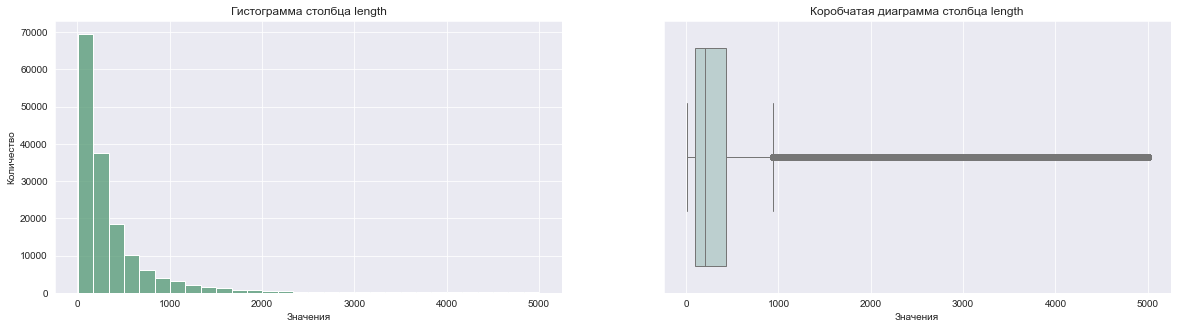

In [28]:
plot_graphics(df, 'length', figsize=(20, 5))

- Видим, что подавляющее большинство комментов имеют длину не больше 2500 символов
- Однако есть тяжелый хвост справа вплоть до 5000 символов

In [29]:
df.pivot_table(
    index='toxic',           
    values='length',
    aggfunc={
        'length': [('2.5% процентиль', lambda x: np.quantile(x, 0.025)),
                   ('97.5% процентиль', lambda x: np.quantile(x, 0.975)),
                   ('Медианная длина твитов', 'median')
                  ]
    }
)

,2.5% процентиль,97.5% процентиль,Медианная длина твитов
toxic,,,
0,27.0,2030.000,216.0
1,23.0,1787.125,128.0


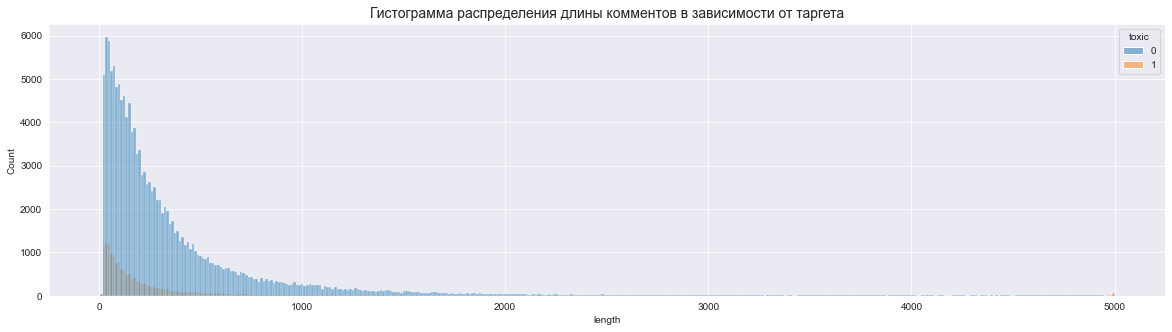

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

g = sns.histplot(data=df, 
                 x='length', 
                 hue='toxic', 
                 ax=ax)

ax.set_title('Гистограмма распределения длины комментов в зависимости от таргета', 
             fontdict={'fontsize': 14});

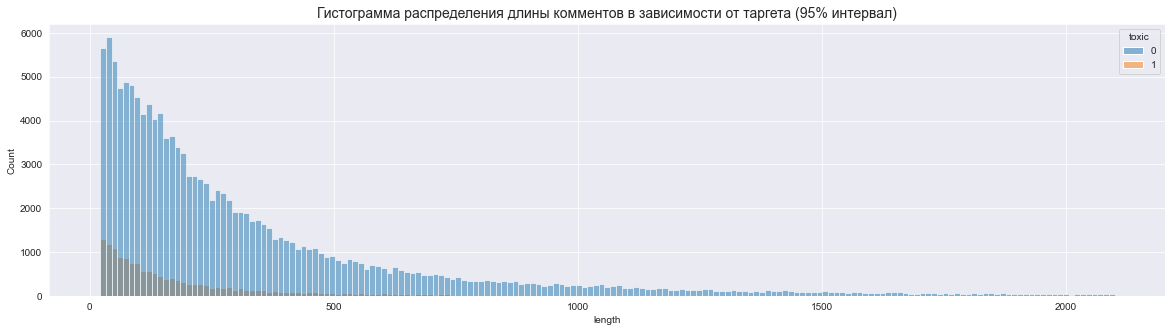

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

g = sns.histplot(data=df.query('20 < length < 2100'), 
                 x='length', 
                 hue='toxic', 
                 ax=ax)

ax.set_title('Гистограмма распределения длины комментов в зависимости от таргета (95% интервал)', 
             fontdict={'fontsize': 14});

- Заметим, что основная часть токсичных комментов имеет длину не больше 500 символов
- Нетоксичные комментарии же наоборот могут быть достаточно длинными, в основном вплоть до 1500 символов
- Медианная длина нетоксичных комментов - 216 символов, токсичных - 128 символов

## Исследование количества слов в комментах

In [32]:
def word_count(comment):
    comment_list = comment.split()
    return len(comment_list)

In [33]:
df['word_count'] = df['text'].apply(word_count)

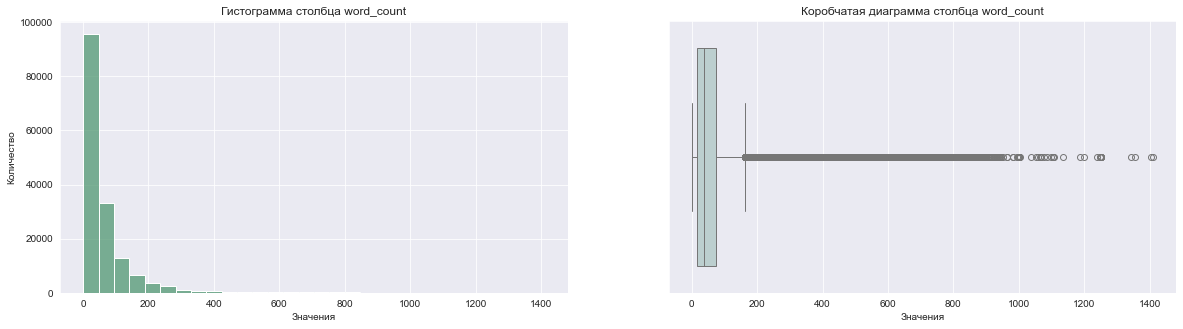

In [34]:
plot_graphics(df, 'word_count', figsize=(20, 5))

In [35]:
df.pivot_table(
    index='toxic',           
    values='word_count',
    aggfunc={
        'word_count': [('5% процентиль', lambda x: np.quantile(x, 0.05)),
                   ('95% процентиль', lambda x: np.quantile(x, 0.95)),
                   ('Медианное количество слов в коментах', 'median')
                  ]
    }
)

,5% процентиль,95% процентиль,Медианное количество слов в коментах
toxic,,,
0,6.0,235.0,37.0
1,5.0,176.0,23.0


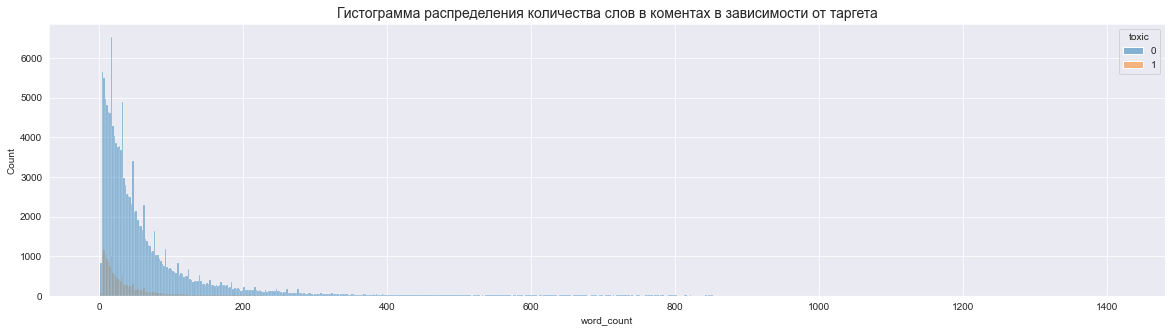

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

g = sns.histplot(data=df, 
                 x='word_count', 
                 hue='toxic', 
                 ax=ax)

ax.set_title('Гистограмма распределения количества слов в коментах в зависимости от таргета', 
             fontdict={'fontsize': 14});

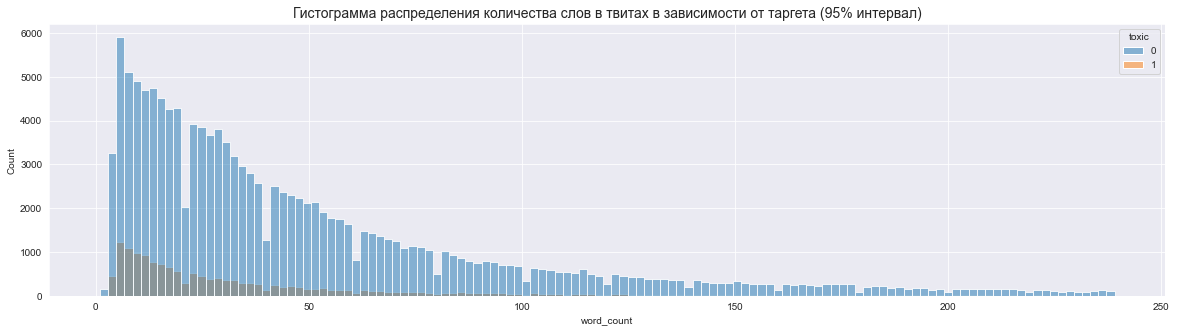

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

g = sns.histplot(data=df.query('0 < word_count < 240'), 
                 x='word_count', 
                 hue='toxic', 
                 ax=ax)

ax.set_title('Гистограмма распределения количества слов в твитах в зависимости от таргета (95% интервал)', 
             fontdict={'fontsize': 14});

- Заметим, что в основной части токсичных твитов не больше 100 слов
- Нетоксичные комментарии же наоборот могут быть достаточно многословными, в основном вплоть до 240 слов
- Медианное количество слов в нетоксичных твитах - 37 слов, в токсичных - 23 слова

## Очищение текста и лемматизация

In [38]:
def lemmatize_array(text):
    text = text.lower()
    text = re.sub(r"[^\w\s']", ' ', text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return lemmas

In [39]:
example = df.loc[1, 'text']
print(f'source sentence: {example},\n\n\nlemmatized: {" ".join(lemmatize_array(example))}' )

source sentence: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC),


lemmatized: match background colour seemingly stuck thank talk january utc


In [40]:
pandarallel.initialize(progress_bar=True)

df['lemmatized_array'] = df['text'].parallel_apply(lemmatize_array)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [41]:
df['lemmatized_text'] = df['lemmatized_array'].str.join(' ')

In [42]:
df.isna().sum()

text                0
toxic               0
length              0
word_count          0
lemmatized_array    0
lemmatized_text     0
dtype: int64

Для построения биграмм необходимо избавиться от пропусков, их очень мало, поэтому просто удалим их

In [43]:
df = df.dropna()

## Исследование слов в комментариях

In [44]:
words_toxic = []
words_no_toxic = []

for i in df.query('toxic == 1').index:
    words_toxic.extend(str(df.loc[i,'lemmatized_text']).split(' '))
    
for i in df.query('toxic == 0').index:
    words_no_toxic.extend(str(df.loc[i,'lemmatized_text']).split(' '))

In [45]:
def get_words_and_freqs(most_frequent):
    words = []
    freqs = []
    
    for pair in most_frequent:
        words.append(pair[0])
        freqs.append(pair[1])     
        
    return words, freqs

In [46]:
most_frequent_toxic = Counter(words_toxic).most_common(10)

In [47]:
most_frequent_no_toxic = Counter(words_no_toxic).most_common(10)

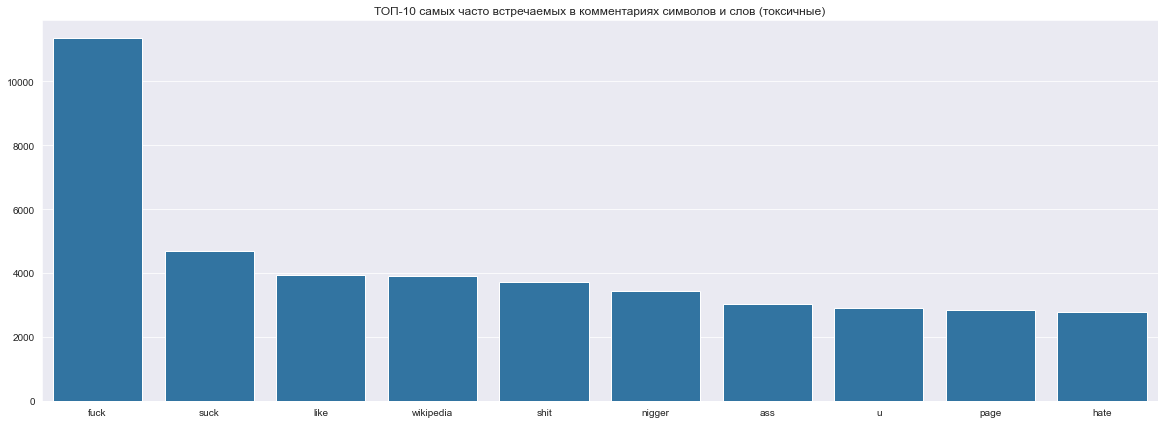

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

words, freqs = get_words_and_freqs(most_frequent_toxic)

sns.barplot(y=freqs, x=words, ax=ax)
plt.title('ТОП-10 самых часто встречаемых в комментариях символов и слов (токсичные)')
plt.show()

- Видим, что среди токсичных комментариев самые популярные слова являются нецензурными....

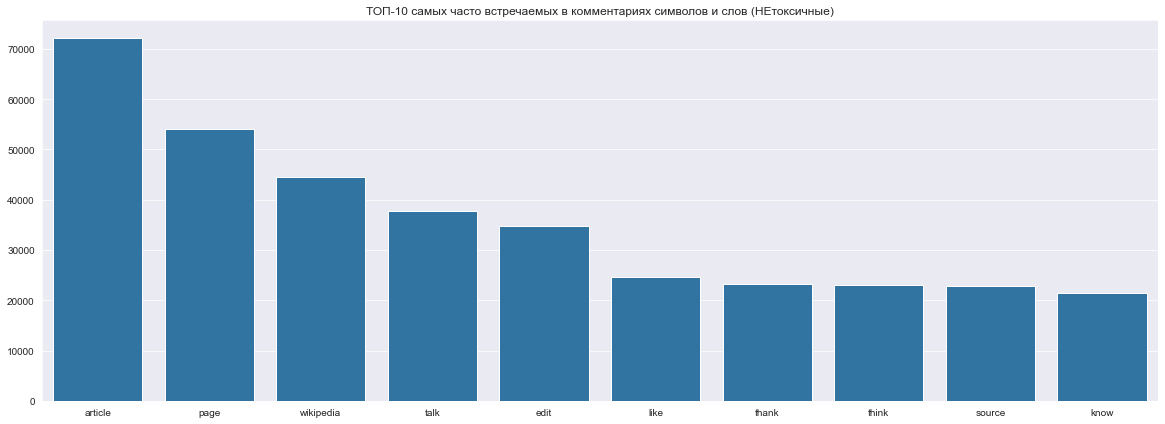

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

words, freqs = get_words_and_freqs(most_frequent_no_toxic)

sns.barplot(y=freqs, x=words, ax=ax)
plt.title('ТОП-10 самых часто встречаемых в комментариях символов и слов (НЕтоксичные)')
plt.show()

- Среди нетоксичных комментариев самыми популярными словами являются: `article`, `page` и `wikipedia`

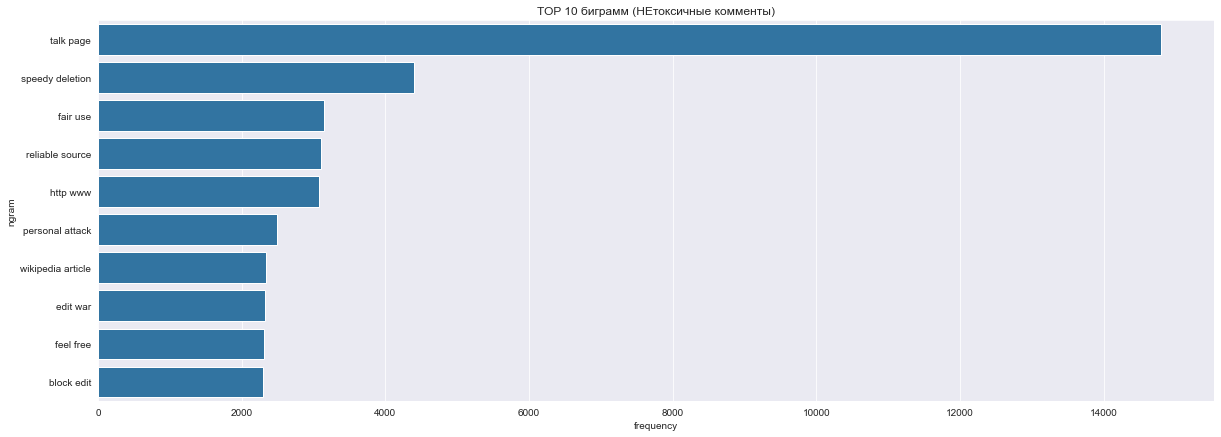

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

count_vectorizer = CountVectorizer(ngram_range=(2,2))
bigrams = count_vectorizer.fit_transform(df.query('toxic == 0')['lemmatized_text'])

count_values = bigrams.sum(axis=0).A1
ngram_freq = pd.DataFrame({
    'ngram': count_vectorizer.get_feature_names_out(),
    'frequency': count_values
}).sort_values('frequency', ascending=False)

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], ax=ax)
plt.title('TOP 10 биграмм (НЕтоксичные комменты)')
plt.show()

- Среди биграмм самой популярной является биграмма - talk page
- Остальные видны на диаграмме выше

# Обучение моделей

## Вычисление TF-IDF и подготовка данных для передачи в модель 

In [51]:
count_tf_idf = TfidfVectorizer() 

In [52]:
target = df.toxic

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], 
                                                    target, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=target, 
                                                    random_state=RANDOM_STATE)

In [54]:
X_train = count_tf_idf.fit_transform(X_train)

In [55]:
X_test = count_tf_idf.transform(X_test)

## Логистическая регрессия

In [56]:
pipe = Pipeline([
    ('models', LogisticRegression())
])

In [ ]:
param_grid_logreg = [
    {
        'models': [LogisticRegression()],
        'models__C': range(5, 15),
        'models__penalty': ['l2'],
        'models__class_weight': ['balanced', None]
        
    }
]

logreg_pipe = RandomizedSearchCV(
    pipe, 
    param_grid_logreg, 
    cv=5,
    scoring='f1',
    error_score='raise',
    random_state=RANDOM_STATE,
    verbose=20
)

logreg_pipe.fit(X_train, y_train)

In [58]:
logreg_pipe.best_params_

{'models__penalty': 'l2',
 'models__class_weight': None,
 'models__C': 12,
 'models': LogisticRegression()}

In [59]:
logreg = logreg_pipe.best_estimator_

In [60]:
logreg_cv = cross_val_score(logreg, 
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring='f1')

In [61]:
print(f'Среднее значение F1 на кросс-валидации: {logreg_cv.mean().round(3)}')

Среднее значение F1 на кросс-валидации: 0.772


## LGBM

In [62]:
boosting = LGBMClassifier(n_jobs=-1, 
                          n_estimators=100, 
                          class_weight='balanced', 
                          random_state=RANDOM_STATE)

In [ ]:
lgbm_cv = cross_val_score(boosting, 
                          X_train, 
                          y_train, 
                          cv=5, 
                          n_jobs=-1, 
                          scoring='f1')

In [64]:
print(f'Среднее значение F1 на кросс-валидации: {lgbm_cv.mean().round(3)}')

Среднее значение F1 на кросс-валидации: 0.743


## Дерево решений

In [65]:
dec_tree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

In [ ]:
dec_cv = cross_val_score(dec_tree, 
                         X_train, 
                         y_train, 
                         cv=5,
                         n_jobs=-1, 
                         scoring='f1')

In [67]:
print(f'Среднее значение F1 на кросс-валидации: {dec_cv.mean().round(3)}')

Среднее значение F1 на кросс-валидации: 0.664


- На кросс-валидации лучший результат показала логистическая регрессия, именно ее и будем использовать для итоговой оценки
- Слабое звено исследования - дерево решений. Данная модель показала самый низкий средний скор

## Итоговая оценка

In [68]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('models', LogisticRegression(C=12))])

In [72]:
round(f1_score(y_test, logreg.predict(X_test)), 2)

0.78

- На тестовых данных модель показала неплохой результат, он удовлетворяет требованиям проекта
$$ F_1 = 0.78 \geqslant 0.75 $$

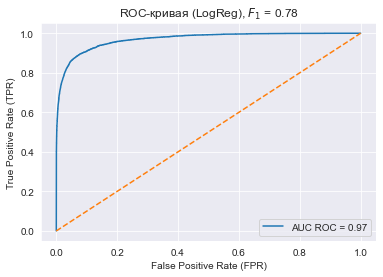

[LightGBM] [Info] Number of positive: 9712, number of negative: 85863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 16.531622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413949
[LightGBM] [Info] Number of data points in the train set: 95575, number of used features: 8068
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 9712, number of negative: 85863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 23.972352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413533
[LightGBM] [Info] Number of data points in the train set: 95575, number of used features: 8089
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0000

In [70]:
fpr, tpr, threshold = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f"ROC-кривая (LogReg), $F_1$ = {round(f1_score(y_test, logreg.predict(X_test)), 2)}")
plt.xlabel('False Positive Rate (FPR)')
plt.legend([f'AUC ROC = {roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]).round(2)}'])
plt.ylabel('True Positive Rate (TPR)');

# Итоговый вывод

- Данные не сожержат явных дубликатов и пропусков
- В целевой переменной датасета есть существенный дисбаланс
- Далее было получено распределение длины комментариев: 
    - Подавляющее большинство комментов имеют длину не больше 2500 символов
    - Однако есть тяжелый хвост справа вплоть до 5000 символов
    - Основная часть токсичных комментов имеет длину не больше 500 символов
    - Нетоксичные комментарии же наоборот могут быть достаточно длинными, в основном вплоть до 1500 символов
    - Медианная длина нетоксичных комментов - 216 символов, токсичных - 128 символов
- Также было исследовано распределение количества слов в комментариях
    - В основной части токсичных твитов не больше 100 слов
    - Нетоксичные комментарии же наоборот могут быть достаточно многословными, в основном вплоть до 240 слов
    - Медианное количество слов в нетоксичных твитах - 37 слов, в токсичных - 23 слова
- Далее текст был очищен и лемматизирован
- На основе корпуса слов, полученного после лемматизации были исследованы слова в исходной форме и биграммы
    - Среди токсичных комментариев самые популярные слова являются нецензурными....
    - Среди нетоксичных комментариев самыми популярными словами являются: `article`, `page` и `wikipedia`
    - Среди биграмм самой популярной является биграмма - talk page
- Затем с помощью TFIDFVectorizer были получены эмбеддинги, из которых сформирован датасет для обучения и теста
- Обучены 4 модели: логистическая регрессия, градиентный бустинг и простое дерево решений
- На кросс-валидации лучшей себя показала модель логистической регрессии
- На контрольном тестировании модель показала метрику $F_1 = 0.78$, что удовлетворяет условиям проекта